In [1]:
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import argparse
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from matplotlib.backends.backend_pdf import PdfPages
import scipy as sp
import uncertainties as unc
import uncertainties
from uncertainties import unumpy as unp
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import matplotlib as mp
import os

In [2]:
cosmo=FlatLambdaCDM(H0=70.0,Om0=0.3)
fit=LevMarLSQFitter()
GAL_ALPHA=-1.05
LCBG_ALPHA=-1.0

In [3]:
def autolabel(rects,thecolor,row,col,standard_height=0):
    for rect in rects:
        if rect.xy[0]<-16:
            height=rect.get_height()
            if not standard_height:
                if not m.isinf(height):
                    axes[row][col].text(rect.get_x() + rect.get_width()/2.,height+0.05,'{}'.format(int(np.round(np.power(10,height)))),ha='center',va='bottom',fontsize=7,color=thecolor)
            else:
                if not m.isinf(height):
                    axes[row][col].text(rect.get_x() + rect.get_width()/2.,standard_height,'{}'.format(int(np.round(np.power(10,height)))),ha='center',va='bottom',fontsize=7,color=thecolor)

In [4]:
@custom_model
def schechter_func_gal(x,phistar=0.0056,mstar=-21):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(GAL_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

In [5]:
@custom_model
def schechter_func_lcbg(x,phistar=0.0056,mstar=-21):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(LCBG_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

In [6]:
def schechter_func_scipy_gal(x,phistar,mstar):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(GAL_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

In [7]:
def schechter_func_scipy_lcbg(x,phistar,mstar):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(LCBG_ALPHA+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

In [8]:
def ap_fitting_gal(DATAFRAME,MASK=None):
    if MASK is None:
        MASK=[]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    print(NUMBDENS.compressed())
    #******MODELLING******
    LFFIT_INIT=schechter_func_gal()
    LFFIT=fit(LFFIT_INIT,MBINAVE.compressed(),NUMBDENS.compressed(),weights=1/NUMBDENSERR.compressed())
    return LFFIT,NUMBDENS.mask

In [9]:
def ap_fitting_lcbg(DATAFRAME,MASK=None):
    if MASK is None:
        MASK=[]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    print(NUMBDENS.compressed())
    #******MODELLING******
    LFFIT_INIT=schechter_func_lcbg()
    LFFIT=fit(LFFIT_INIT,MBINAVE.compressed(),NUMBDENS.compressed(),weights=1/NUMBDENSERR.compressed())
    return LFFIT,NUMBDENS.mask

In [10]:
def sp_fitting_gal(DATAFRAME,MASK=None,INITARRAY=None):
    if MASK is None:
        MASK=[]
    if INITARRAY==None:
        INITARRAY=[0.0056,-21]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    #******MODELLING******
    LFFIT,LFCOV=sp.optimize.curve_fit(schechter_func_scipy_gal,MBINAVE.compressed(),NUMBDENS.compressed(),p0=INITARRAY,sigma=NUMBDENSERR.compressed())
    return LFFIT,LFCOV

In [11]:
def sp_fitting_lcbg(DATAFRAME,MASK=None,INITARRAY=None):
    if MASK is None:
        MASK=[]
    if INITARRAY==None:
        INITARRAY=[0.0056,-21]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    #******MODELLING******
    LFFIT,LFCOV=sp.optimize.curve_fit(schechter_func_scipy_lcbg,MBINAVE.compressed(),NUMBDENS.compressed(),p0=INITARRAY,sigma=NUMBDENSERR.compressed())
    return LFFIT,LFCOV

In [16]:
LCBG_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/LCBGLFOUT/apmag225/zucca_z_bins/'
LCBG_LFS={}
LCBG_LFS_INDEX=[]
for file in os.listdir(LCBG_DIR):
    if file.endswith('csv'):
        print(file)
        LCBG_LFS[file.split('.csv')[0]]=pd.read_csv(LCBG_DIR+'/'+file)
        LCBG_LFS_INDEX.append(file.split('.csv')[0])

LF_10_35_LCBG.csv
LF_35_55_LCBG.csv
LF_55_75_LCBG.csv
LF_75_100_LCBG.csv
zLF_30_80.csv


In [17]:
ORIG_LCBG_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/LCBGLFOUT/apmag225/orig_z_bins/'
ORIG_LCBG_LFS={}
ORIG_LCBG_LFS_INDEX=[]
for file in os.listdir(ORIG_LCBG_DIR):
    if file.endswith('csv'):
        print(file)
        ORIG_LCBG_LFS[file.split('.csv')[0]]=pd.read_csv(ORIG_LCBG_DIR+'/'+file)
        ORIG_LCBG_LFS_INDEX.append(file.split('.csv')[0])

LF_1_20_LCBG.csv
LF_20_40_LCBG.csv
LF_40_60_LCBG.csv
LF_60_80_LCBG.csv
LF_80_100_LCBG.csv


In [18]:
GAL_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT/apmag225/zucca_z_bins/'
GAL_LFS={}
GAL_LFS_INDEX=[]
for file in os.listdir(GAL_DIR):
    if file.endswith('csv'):
        GAL_LFS[file.split('.csv')[0]]=pd.read_csv(GAL_DIR+'/'+file)
        GAL_LFS_INDEX.append(file.split('.csv')[0])

In [19]:
ORIG_GAL_DIR='/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT/apmag225/orig_z_bins/'
ORIG_GAL_LFS={}
ORIG_GAL_LFS_INDEX=[]
for file in os.listdir(ORIG_GAL_DIR):
    if file.endswith('csv'):
        ORIG_GAL_LFS[file.split('.csv')[0]]=pd.read_csv(ORIG_GAL_DIR+'/'+file)
        ORIG_GAL_LFS_INDEX.append(file.split('.csv')[0])

In [20]:
LCBG_MASKS={LCBG_LFS_INDEX[0]:[],LCBG_LFS_INDEX[1]:[12,13,14],LCBG_LFS_INDEX[2]:[9,10,11,12,13,14],LCBG_LFS_INDEX[3]:[0,1,2,7,8,9,10,11,12,13,14,15,16,17],LCBG_LFS_INDEX[4]:[12,13,14,15,16,17]}
GAL_MASKS={GAL_LFS_INDEX[0]:[],GAL_LFS_INDEX[1]:[12,13,14],GAL_LFS_INDEX[2]:[9,10,11,12,13,14],GAL_LFS_INDEX[3]:[7,8,9,10,11,12,13,14,15,16,17],GAL_LFS_INDEX[4]:[12,13,14,15,16,17]}

In [21]:
LCBG_MASKS={LCBG_LFS_INDEX[0]:[0,1,2,14,15,16,17],LCBG_LFS_INDEX[1]:[0,1,2,10,11,12,13,14],LCBG_LFS_INDEX[2]:[0,1,2,8,9,10,11,12,13,14],LCBG_LFS_INDEX[3]:[0,1,7,8,9,10,11,12,13,14,15,16,17],LCBG_LFS_INDEX[4]:[0,1,12,13,14,15,16,17]}
GAL_MASKS={GAL_LFS_INDEX[0]:[0,1,2,14,15,16,17],GAL_LFS_INDEX[1]:[10,11,12,13,14],GAL_LFS_INDEX[2]:[0,1,8,9,10,11,12,13,14],GAL_LFS_INDEX[3]:[0,7,8,9,10,11,12,13,14,15,16,17],GAL_LFS_INDEX[4]:[0,1,12,13,14,15,16,17]}

In [22]:
ORIG_LCBG_MASKS={ORIG_LCBG_LFS_INDEX[0]:[0,1,2,14,15,16,17],ORIG_LCBG_LFS_INDEX[1]:[0,1,2,10,11,12,13,14],ORIG_LCBG_LFS_INDEX[2]:[0,1,2,8,9,10,11,12,13,14],ORIG_LCBG_LFS_INDEX[3]:[0,1,7,8,9,10,11,12,13,14,15,16,17],ORIG_LCBG_LFS_INDEX[4]:[0,1,12,13,14,15,16,17]}
ORIG_GAL_MASKS={ORIG_GAL_LFS_INDEX[0]:[0,1,2,14,15,16,17],ORIG_GAL_LFS_INDEX[1]:[10,11,12,13,14],ORIG_GAL_LFS_INDEX[2]:[0,1,8,9,10,11,12,13,14],ORIG_GAL_LFS_INDEX[3]:[0,7,8,9,10,11,12,13,14,15,16,17],ORIG_GAL_LFS_INDEX[4]:[0,1,12,13,14,15,16,17]}

In [23]:
ORIG_LCBG_MASKS

{'LF_1_20_LCBG': [0, 1, 2, 14, 15, 16, 17],
 'LF_20_40_LCBG': [0, 1, 2, 10, 11, 12, 13, 14],
 'LF_40_60_LCBG': [0, 1, 2, 8, 9, 10, 11, 12, 13, 14],
 'LF_60_80_LCBG': [0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'LF_80_100_LCBG': [0, 1, 12, 13, 14, 15, 16, 17]}

In [24]:
LCBG_FITS_AP={}
LCBG_FITS_AP_INDEX=[]
for index in LCBG_LFS_INDEX:
    LCBG_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting_lcbg(LCBG_LFS[index],MASK=LCBG_MASKS[index])
    LCBG_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
LCBG_FITS_SP={}
LCBG_FITS_SP_INDEX=[]
for index in LCBG_LFS_INDEX:
    LCBG_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting_lcbg(LCBG_LFS[index],MASK=LCBG_MASKS[index])
    LCBG_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')

[3.88309294e-05 2.09689260e-04 4.11921946e-04 6.44976535e-04
 7.19701437e-04 9.37092577e-04 1.03893955e-03]
[2.08197684e-05 9.91660177e-05 3.05321945e-04 5.64217530e-04
 8.95283052e-04 1.25464917e-03 1.38373013e-03]
[2.76136761e-05 1.90660449e-04 5.34830678e-04 9.93091424e-04
 1.65637663e-03]
[1.04639596e-05 6.19733206e-05 2.96790527e-04 8.27359142e-04
 1.45524778e-03]
[7.59453123e-06 2.46949014e-05 1.52430076e-04 4.34269252e-04
 8.17079068e-04 1.30345264e-03 1.25943924e-03 1.35632472e-03
 1.47079447e-03]


In [25]:
ORIG_LCBG_FITS_AP={}
ORIG_LCBG_FITS_AP_INDEX=[]
for index in ORIG_LCBG_LFS_INDEX:
    ORIG_LCBG_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting_lcbg(ORIG_LCBG_LFS[index],MASK=ORIG_LCBG_MASKS[index])
    ORIG_LCBG_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
ORIG_LCBG_FITS_SP={}
ORIG_LCBG_FITS_SP_INDEX=[]
for index in ORIG_LCBG_LFS_INDEX:
    ORIG_LCBG_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting_lcbg(ORIG_LCBG_LFS[index],MASK=ORIG_LCBG_MASKS[index])
    ORIG_LCBG_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')

[5.53636118e-04 8.19168985e-05 3.83880804e-04 2.82572587e-04
 2.25615777e-04 4.50154014e-04]
[4.08790339e-05 2.61601437e-04 5.62225410e-04 8.36256232e-04
 1.05554961e-03 1.39082496e-03]
[1.78630676e-05 1.14853584e-04 2.42743550e-04 5.16483288e-04
 8.45310193e-04]
[8.42986207e-06 3.36690734e-05 1.92937378e-04 5.79797798e-04
 1.04365807e-03]
[8.45922258e-06 6.88072284e-05 3.29206700e-04 9.22860239e-04
 1.63526200e-03 3.84883326e-04]


In [26]:
GAL_FITS_AP={}
GAL_FITS_AP_INDEX=[]
for index in GAL_LFS_INDEX:
    GAL_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting_gal(GAL_LFS[index],MASK=GAL_MASKS[index])
    GAL_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
GAL_FITS_SP={}
GAL_FITS_SP_INDEX=[]
GAL_FITS_UNCERTAINTIES={}
for index in GAL_LFS_INDEX:
    GAL_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting_gal(GAL_LFS[index],MASK=GAL_MASKS[index])
    GAL_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')

[4.35204484e-05 3.90956996e-04 1.06433704e-03 1.89980956e-03
 3.17913630e-03 4.23473684e-03 4.78368528e-03 6.16771388e-03
 6.80547699e-03 6.55525726e-03 7.75368194e-03]
[3.90196265e-06 3.07966351e-05 9.60147277e-05 3.99841976e-04
 1.04194817e-03 2.01964815e-03 2.87975770e-03 3.56893989e-03
 4.47730044e-03]
[3.49547729e-05 2.32957366e-04 6.60515844e-04 1.66001337e-03
 2.53645098e-03 3.70743764e-03]
[5.37942022e-06 5.46053990e-05 3.24140254e-04 9.58093906e-04
 1.97237802e-03 2.83414351e-03]
[3.25823790e-05 1.62859190e-04 5.41621554e-04 1.36090978e-03
 2.27913103e-03 3.33186153e-03 3.56125077e-03 4.54626722e-03
 6.11419520e-03 9.00644107e-03]


In [27]:
ORIG_GAL_FITS_AP={}
ORIG_GAL_FITS_AP_INDEX=[]
for index in ORIG_GAL_LFS_INDEX:
    ORIG_GAL_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting_gal(ORIG_GAL_LFS[index],MASK=ORIG_GAL_MASKS[index])
    ORIG_GAL_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
ORIG_GAL_FITS_SP={}
ORIG_GAL_FITS_SP_INDEX=[]
ORIG_GAL_FITS_UNCERTAINTIES={}
for index in ORIG_GAL_LFS_INDEX:
    ORIG_GAL_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting_gal(ORIG_GAL_LFS[index],MASK=ORIG_GAL_MASKS[index])
    ORIG_GAL_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')

[0.00020073 0.00016128 0.0007416  0.0011575  0.00180588 0.00264688
 0.00302145 0.00484003 0.00622154 0.00616003 0.00866897]
[1.42662659e-05 2.93741304e-05 7.05923086e-05 4.70961363e-04
 1.25400313e-03 2.43347282e-03 3.88626306e-03 4.99254272e-03
 5.77110643e-03 3.55380659e-04]
[1.63263594e-05 8.53400880e-05 3.41752618e-04 8.49360451e-04
 1.61738406e-03 2.26745604e-03]
[2.10352184e-06 4.04884003e-05 2.25925693e-04 6.62679595e-04
 1.65217455e-03 2.58814578e-03]
[5.81787009e-05 3.73795082e-04 1.07710019e-03 2.24157889e-03
 3.24610369e-03 9.06522561e-04]


In [28]:
LCBG_VAL_ERROR_TO_DATAFRAME={}
for index in LCBG_FITS_SP_INDEX:
    LCBG_VAL_ERROR_TO_DATAFRAME[
        index.split('_sp')[0]
    ]=[uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[0].nominal_value,
      uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[0].std_dev,
      uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[1].nominal_value,
      uncertainties.correlated_values(LCBG_FITS_SP[index][0],
                                       LCBG_FITS_SP[index][1])[1].std_dev] 

In [29]:
ORIG_LCBG_VAL_ERROR_TO_DATAFRAME={}
for index in ORIG_LCBG_FITS_SP_INDEX:
    ORIG_LCBG_VAL_ERROR_TO_DATAFRAME[
        index.split('_sp')[0]
    ]=[uncertainties.correlated_values(ORIG_LCBG_FITS_SP[index][0],
                                       ORIG_LCBG_FITS_SP[index][1])[0].nominal_value,
      uncertainties.correlated_values(ORIG_LCBG_FITS_SP[index][0],
                                       ORIG_LCBG_FITS_SP[index][1])[0].std_dev,
      uncertainties.correlated_values(ORIG_LCBG_FITS_SP[index][0],
                                       ORIG_LCBG_FITS_SP[index][1])[1].nominal_value,
      uncertainties.correlated_values(ORIG_LCBG_FITS_SP[index][0],
                                       ORIG_LCBG_FITS_SP[index][1])[1].std_dev] 

In [30]:
GAL_VAL_ERROR_TO_DATAFRAME={}
for index in GAL_FITS_SP_INDEX:
    GAL_VAL_ERROR_TO_DATAFRAME[
        index.split('_sp')[0]
    ]=[uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[0].nominal_value,
      uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[0].std_dev,
      uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[1].nominal_value,
      uncertainties.correlated_values(GAL_FITS_SP[index][0],
                                       GAL_FITS_SP[index][1])[1].std_dev] 

In [31]:
ORIG_GAL_VAL_ERROR_TO_DATAFRAME={}
for index in ORIG_GAL_FITS_SP_INDEX:
    ORIG_GAL_VAL_ERROR_TO_DATAFRAME[
        index.split('_sp')[0]
    ]=[uncertainties.correlated_values(ORIG_GAL_FITS_SP[index][0],
                                       ORIG_GAL_FITS_SP[index][1])[0].nominal_value,
      uncertainties.correlated_values(ORIG_GAL_FITS_SP[index][0],
                                       ORIG_GAL_FITS_SP[index][1])[0].std_dev,
      uncertainties.correlated_values(ORIG_GAL_FITS_SP[index][0],
                                       ORIG_GAL_FITS_SP[index][1])[1].nominal_value,
      uncertainties.correlated_values(ORIG_GAL_FITS_SP[index][0],
                                       ORIG_GAL_FITS_SP[index][1])[1].std_dev] 

In [32]:
GAL_LUMFUNC_FIT_VALS_ERRS=pd.DataFrame.from_dict(GAL_VAL_ERROR_TO_DATAFRAME,
                                                 orient='index',
                                                 columns=['PHI','PHI_err','M','M_err'])

In [33]:
ORIG_GAL_LUMFUNC_FIT_VALS_ERRS=pd.DataFrame.from_dict(ORIG_GAL_VAL_ERROR_TO_DATAFRAME,
                                                 orient='index',
                                                 columns=['PHI','PHI_err','M','M_err'])

In [34]:
LCBG_LUMFUNC_FIT_VALS_ERRS=pd.DataFrame.from_dict(LCBG_VAL_ERROR_TO_DATAFRAME,
                                                 orient='index',
                                                 columns=['PHI','PHI_err','M','M_err'])

In [35]:
ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS=pd.DataFrame.from_dict(ORIG_LCBG_VAL_ERROR_TO_DATAFRAME,
                                                 orient='index',
                                                 columns=['PHI','PHI_err','M','M_err'])

In [36]:
WILLMER=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/WILLMER.txt')
FABER=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/FABER.txt')
COOL=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/COOL.txt')
ZUCCA=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/ZUCCA.txt')
FRITZ=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/FRITZ.txt')
BEARE=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/BEARE.txt')
BEAREALPH=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/BEARE_CONSTANTALPHA.txt')
ZUCCAALPH=np.loadtxt('/home/lrhunt/Projects/LCBG_LUMINOSITY_FUNCTION_PLOTTING/TXTFILES/OTHERSTUDIES/ZUCCA_CONSTANTALPHA.txt')

BEAREmstaru=unp.uarray(BEAREALPH[:,4],BEAREALPH[:,5])
BEAREphistaru=unp.uarray(BEAREALPH[:,6],BEAREALPH[:,7])
WILLMERmstaru=unp.uarray(WILLMER[:,4],WILLMER[:,5])
WILLMERphistaru=unp.uarray(WILLMER[:,6],WILLMER[:,7])
FABERmstaru=unp.uarray(FABER[:,4],FABER[:,5])
FABERphistaru=unp.uarray(FABER[:,6],FABER[:,7])
COOLmstaru=unp.uarray(COOL[:,4],COOL[:,5])
COOLphistaru=unp.uarray(COOL[:,6],COOL[:,7])
ZUCCAmstaru=unp.uarray(ZUCCAALPH[:,4],ZUCCAALPH[:,5])
ZUCCAphistaru=unp.uarray(ZUCCAALPH[:,6],ZUCCAALPH[:,7])
FRITZmstaru=unp.uarray(FRITZ[:,4],FRITZ[:,5])
FRITZphistaru=unp.uarray(FRITZ[:,6],FRITZ[:,7])

In [38]:
for index in GAL_LUMFUNC_FIT_VALS_ERRS.index:
    GAL_LUMFUNC_FIT_VALS_ERRS.loc[index,'z']=np.mean([float(index.split('_')[0]),float(index.split('_')[1])])/100

In [39]:
for index in ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.index:
    ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.loc[index,'z']=np.mean([float(index.split('_')[0]),float(index.split('_')[1])])/100

In [40]:
for index in LCBG_LUMFUNC_FIT_VALS_ERRS.index:
    LCBG_LUMFUNC_FIT_VALS_ERRS.loc[index,'z']=np.mean([float(index.split('_')[0]),float(index.split('_')[1])])/100

In [41]:
for index in ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.index:
    ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.loc[index,'z']=np.mean([float(index.split('_')[0]),float(index.split('_')[1])])/100

In [42]:
LCBG_LUMFUNC_FIT_VALS_ERRS

,PHI,PHI_err,M,M_err,z
10_35_LCBG,0.001410,0.000068,-20.469905,0.063634,0.225
35_55_LCBG,0.002077,0.000047,-20.554817,0.025851,0.450
55_75_LCBG,0.003932,0.000245,-20.494007,0.046844,0.650
75_100_LCBG,0.005133,0.000498,-20.603692,0.054005,0.875
30_80,0.002272,0.000202,-20.688162,0.088077,0.550


Plotting M*

<ErrorbarContainer object of 3 artists>

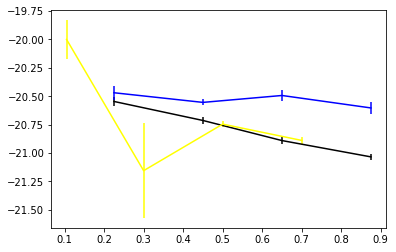

In [44]:
plt.errorbar(GAL_LUMFUNC_FIT_VALS_ERRS.loc[GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'z'],
             GAL_LUMFUNC_FIT_VALS_ERRS.loc[GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'M'],
             yerr=GAL_LUMFUNC_FIT_VALS_ERRS.loc[GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'M_err'],
             color='black')
plt.errorbar(ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'z'],
             ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'M'],
             yerr=ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'M_err'],
             color='yellow')
plt.errorbar(LCBG_LUMFUNC_FIT_VALS_ERRS.loc[LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:4],'z'],
             LCBG_LUMFUNC_FIT_VALS_ERRS.loc[LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:4],'M'],
             yerr=LCBG_LUMFUNC_FIT_VALS_ERRS.loc[LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:4],'M_err'],
            color='blue')
#plt.errorbar(WILLMER[:,0],
#             WILLMER[:,4],
#             yerr=WILLMER[:,5],
#             color='yellow',
#             fmt='->',
#             label='Willmer, 2006')
#plt.errorbar(FABER[:,0],
#             FABER[:,4],
#             yerr=FABER[:,5],
#             color='green',
#             fmt='-<',
#             label='Faber, 2007')
#plt.errorbar(ZUCCAALPH[:,0],
#             ZUCCAALPH[:,4],
#             yerr=ZUCCAALPH[:,5],
#             color='grey',
#             fmt='-8',
#             label='Zucca, 2009')
#plt.errorbar(COOL[:,0],
#             COOL[:,4],
#             yerr=COOL[:,5],
#             color='red',
#             fmt='-s',
#             label='Cool, 2012')
#plt.errorbar(FRITZ[:,0],
#             FRITZ[:,4],
#             yerr=FRITZ[:,5],
#             color='purple',
#             fmt='-*',
#             label='Fritz, 2014')
#plt.errorbar(BEAREALPH[:,0],
#             BEAREALPH[:,4],
#             yerr=BEAREALPH[:,5],
#             color='slateblue',
#             fmt='-d',
#             label='Beare, 2015')

Plotting phistar

<ErrorbarContainer object of 3 artists>

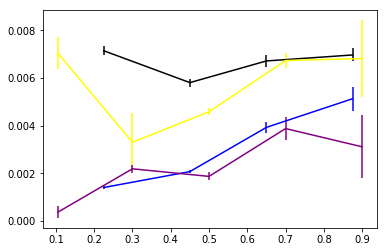

In [45]:
plt.errorbar(GAL_LUMFUNC_FIT_VALS_ERRS.loc[GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'z'],
             GAL_LUMFUNC_FIT_VALS_ERRS.loc[GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'PHI'],
             yerr=GAL_LUMFUNC_FIT_VALS_ERRS.loc[GAL_LUMFUNC_FIT_VALS_ERRS.index[0:4],'PHI_err'],
            color='black')
plt.errorbar(ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.index[0:5],'z'],
             ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.index[0:5],'PHI'],
             yerr=ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_GAL_LUMFUNC_FIT_VALS_ERRS.index[0:5],'PHI_err'],
            color='yellow')
plt.errorbar(LCBG_LUMFUNC_FIT_VALS_ERRS.loc[LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:4],'z'],
             LCBG_LUMFUNC_FIT_VALS_ERRS.loc[LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:4],'PHI'],
             yerr=LCBG_LUMFUNC_FIT_VALS_ERRS.loc[LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:4],'PHI_err'],
            color='blue')
plt.errorbar(ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:5],'z'],
             ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:5],'PHI'],
             yerr=ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.loc[ORIG_LCBG_LUMFUNC_FIT_VALS_ERRS.index[0:5],'PHI_err'],
            color='purple')
#plt.errorbar(WILLMER[:,0],
#             WILLMER[:,6],
#             yerr=WILLMER[:,7],
#             color='yellow',
#             fmt='->',
#             label='Willmer, 2006')
#plt.errorbar(FABER[:,0],
#             FABER[:,6],
#             yerr=FABER[:,7],
#             color='green',
#             fmt='-<',
#             label='Faber, 2007')
#plt.errorbar(ZUCCAALPH[:,0],
#             ZUCCAALPH[:,6],
#             yerr=ZUCCAALPH[:,7],
#             color='grey',
#             fmt='-8',
#             label='Zucca, 2009')
#plt.errorbar(COOL[:,0],
#             COOL[:,6],
#             yerr=COOL[:,7],
#             color='red',
#             fmt='-s',
#             label='Cool, 2012')
#plt.errorbar(FRITZ[:,0],
#             FRITZ[:,6],
#             yerr=FRITZ[:,7],
#             color='purple',
#             fmt='-*',
#             label='Fritz, 2014')
#plt.errorbar(BEAREALPH[:,0],
#             BEAREALPH[:,6],
#             yerr=BEAREALPH[:,7],
#             color='slateblue',
#             fmt='-d',
#             label='Beare, 2015')